### Imports, Setup

In [1]:
import sys
sys.path.append('../SEACells/')

In [2]:
sys.path

['/data/aparna/aparnakumar/SEACells/notebooks',
 '/home/aparna/miniconda/lib/python39.zip',
 '/home/aparna/miniconda/lib/python3.9',
 '/home/aparna/miniconda/lib/python3.9/lib-dynload',
 '',
 '/home/aparna/miniconda/lib/python3.9/site-packages',
 '../SEACells/']

In [3]:
import os 
os.listdir('../SEACells/')

['domainadapt.py',
 'core.py',
 '__init__.py',
 'Rscripts',
 'genescores.py',
 'utils.py',
 'build_graph.py',
 '__pycache__',
 'tfactivity.py',
 'data',
 'plot.py',
 'version.py',
 'evaluate.py',
 'preprocess.py',
 'accessibility.py']

In [4]:
import core
import plot

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [5]:
import numpy as np
from numba import cuda
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import seaborn as sns
import anndata
import scanpy as sc
import pandas as pd
import sklearn
from scipy.sparse import csr_matrix
import copy

In [6]:
import os
import psutil
import tracemalloc
import time

In [7]:
from numba import cuda
import cupy as cp
import cupyx

In [8]:
# Load data
ad = sc.read("/home/aparna/DATA/aparnakumar/mouse_marioni.h5ad")

In [9]:
ad.shape

(116312, 16443)

In [10]:
ad

AnnData object with n_obs × n_vars = 116312 × 16443
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca', 'X_pca_max', 'X_umap'
    layers: 'log', 'norm'

/home/aparna/miniconda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


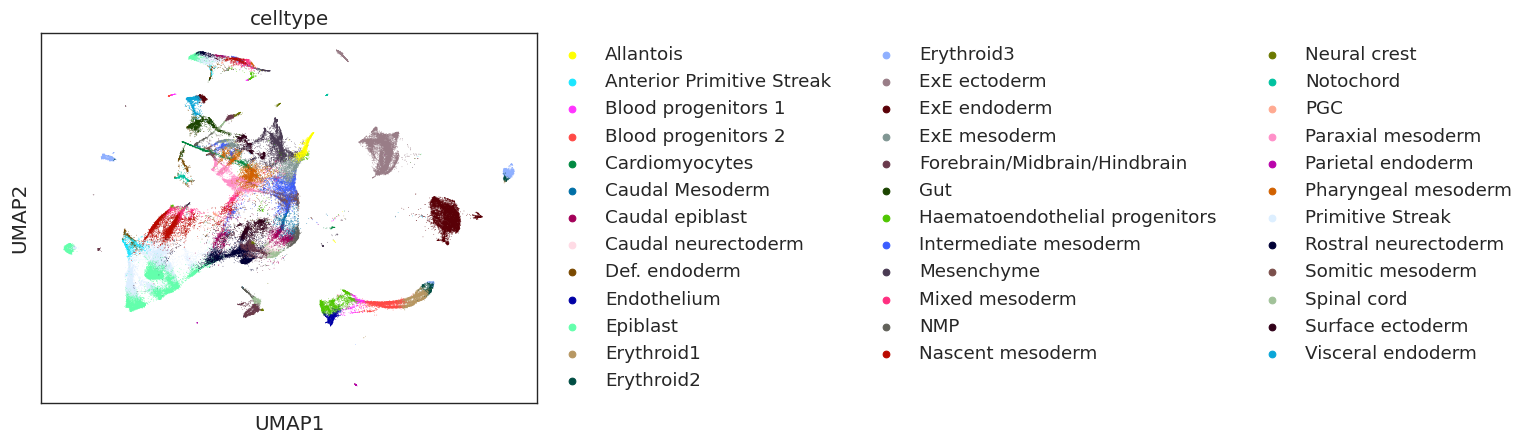

In [11]:
# Plot cell-types for reference
%matplotlib inline
sc.pl.umap(ad, color = 'celltype')
plt.show()

### Functions

In [12]:
# Code for getting memory usage
def process_memory():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss

### Pre-processing

In [13]:
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.X)
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [14]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1500)

In [15]:
# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explaint
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)

In [16]:
ad

AnnData object with n_obs × n_vars = 116312 × 16443
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'celltype_colors', 'pca'
    obsm: 'X_pca', 'X_pca_max', 'X_umap'
    varm: 'PCs'
    layers: 'log', 'norm'

### Create the five versions for comparative purposes

In [17]:
# Going to be dealing with two different versions, so create the versioning split here 
# parametrize this
num_cells = 5000

In [18]:
# control version
ad_1 = ad[:num_cells].copy()

# gpu_version
ad_2 = ad[:num_cells].copy()

In [19]:
print(ad_1.obs.shape)
print(ad_2.obs.shape)

(5000, 28)
(5000, 28)


### Model

#### Model-- general information

* We are choosing the build with PCA (Principal component analysis)
* 90 metacells 

In [20]:
## User defined parameters

## Core parameters 
# number of SEACells
n_SEACells = num_cells // 75
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

#### Model 1 Setup: Control

In [21]:
model_1 = core.SEACells(ad_1, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [22]:
model_1.construct_kernel_matrix()
M_1 = model_1.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/5000 [00:00<?, ?it/s]

Constructing CSR matrix...


In [23]:
model_1.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 57 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 19/19 [00:00<00:00, 257.54it/s]

Selecting 9 cells from greedy initialization.


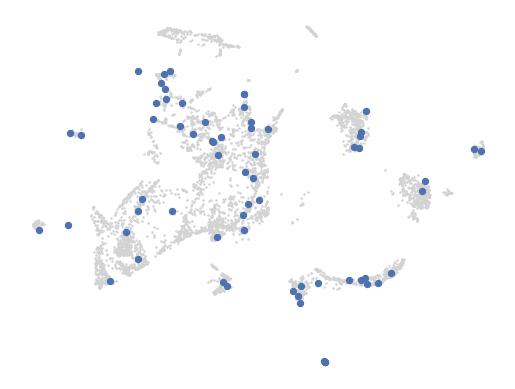

In [24]:
# Plot the initilization to ensure they are spread across phenotypic space
plot.plot_initialization(ad_1, model_1)

In [25]:
# Time consuming cell
start = time.time()
tracemalloc.start()

model_1.fit(min_iter=10, max_iter=150, use_gpu = False)

end = time.time()
time1 = end - start

mem1 = tracemalloc.get_traced_memory()
tracemalloc.stop()

Randomly initialized A matrix.
Setting convergence threshold at 0.00125
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 33 iterations.


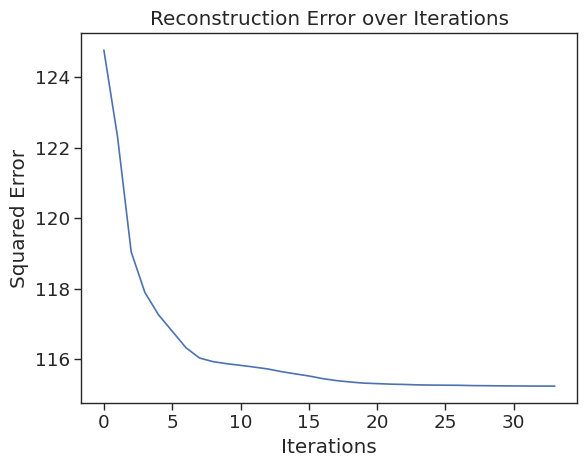

In [26]:
# Check for convergence 
model_1.plot_convergence()

#### Model 2 Setup: GPU Version

In [27]:
model_2 = core.SEACells(ad_2, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [28]:
model_2.construct_kernel_matrix()
M_2 = model_2.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/5000 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/5000 [00:00<?, ?it/s]

Constructing CSR matrix...


In [29]:
model_2.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 58 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 18/18 [00:00<00:00, 254.18it/s]

Selecting 8 cells from greedy initialization.


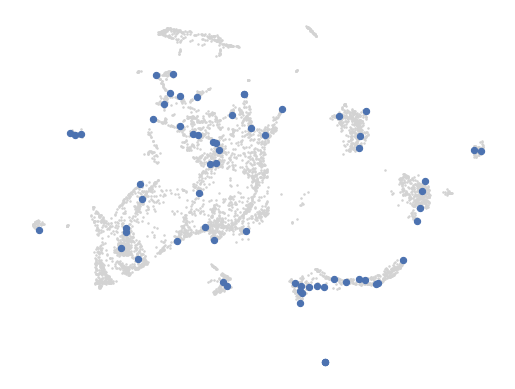

In [30]:
# Plot the initilization to ensure they are spread across phenotypic space
plot.plot_initialization(ad_2, model_2)

In [31]:
start = time.time()
tracemalloc.start()

model_2.fit(min_iter=10, max_iter=150, use_gpu = True)

end = time.time()
time2 = end-start

mem2=tracemalloc.get_traced_memory()
tracemalloc.stop()

Randomly initialized A matrix.
Setting convergence threshold at 0.0012506028551296346
Converged after 33 iterations.


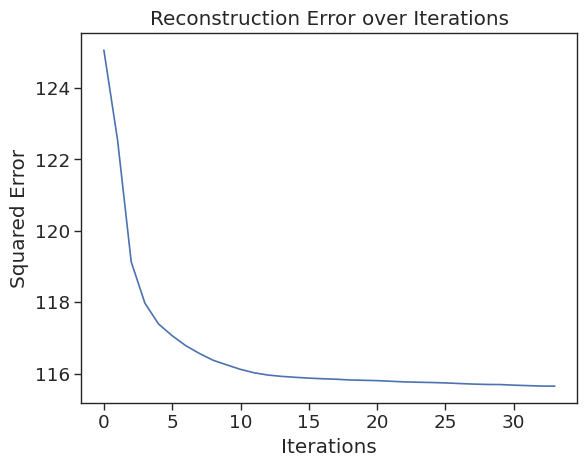

In [32]:
# Check for convergence 
model_2.plot_convergence()

### Results

In [33]:
comparisons = pd.DataFrame({'version': ['control', 'gpu-version'], 
                           'time (s)': [time1, time2],
                           'peak memory': [mem1[1], mem2[1]], 
                           })
comparisons

,version,time (s),peak memory
0,control,119.646099,605628661
1,gpu-version,23.787377,613713729


<AxesSubplot: xlabel='version'>

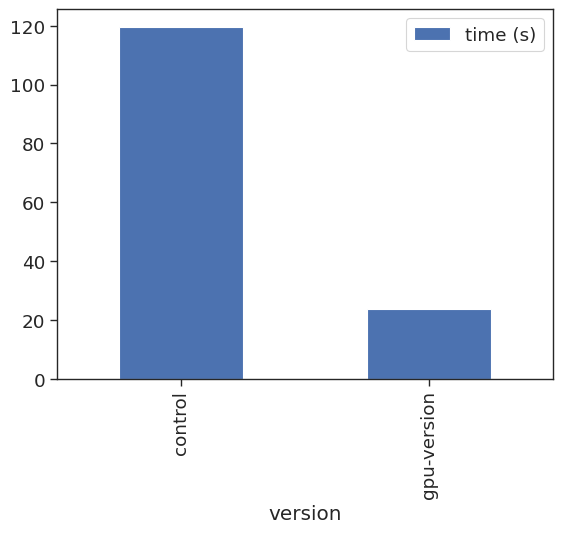

In [34]:
comparisons.plot.bar(x='version', y='time (s)')

<AxesSubplot: xlabel='version'>

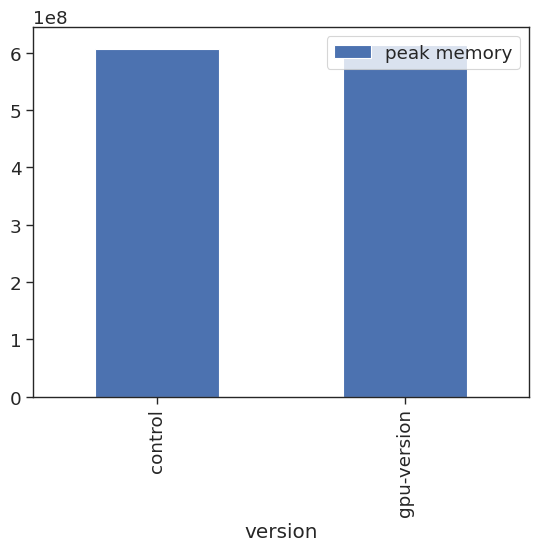

In [35]:
comparisons.plot.bar(x='version', y='peak memory')

In [36]:
# path = "%s_cells/comparisons.csv" % (num_cells)
# comparisons.to_csv(path)

In [37]:
# model_1.get_hard_assignments()

In [38]:
# models = [model_1, model_2]
# for index in range(len(models)): 
#     model = models[index]
#     path = '%s_cells/assignments_v%s.csv' % (num_cells, index+1)
#     model.get_hard_assignments().to_csv(path)
